# Capstone Three: Data Wrangling and EDA

## Overview

In this notebook, we will be using time series data from the US Census Bureau. This data was downloaded from Kaggle [at this link](https://www.kaggle.com/datasets/census/population-time-series-data?resource=download&select=total-population-all-ages-including-armed-forces-overseas_metadata.json), and includes the population of the United States on the first of the month, every month, from January 1952 to December 2019. We are going to make sure that our data is clean and see what shape we are working with.

## 1. Importing our tools

### 1a. Importing useful packages

In [1]:
#Bringing in pandas, matplotlib.pyplot, seaborn, and a tool to save my data with.
import pandas as pd
import matplotlib.pyplot as plt
import os

from library.sb_utils import save_file

### 1b. Importing Relevant Data

In [2]:
raw_data = pd.read_csv('../data/raw/POP.csv')

## 2. Cleaning and transforming

### 2a. Dropping unwanted columns

In [3]:
#Let's see how this dataset looks to start
raw_data.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


The realtime start and realtime end columns don't look very useful, so let's start by dropping those.

In [4]:
raw_data = raw_data.drop(['realtime_start', 'realtime_end'], axis = 1)

In [5]:
raw_data.head()

,value,date
0,156309.0,1952-01-01
1,156527.0,1952-02-01
2,156731.0,1952-03-01
3,156943.0,1952-04-01
4,157140.0,1952-05-01


### 2b. Column Types and setting our index

We should make sure that we have one datetime column and one integer column.

In [6]:
#Check what kind of data types we already have
raw_data.dtypes

value    float64
date      object
dtype: object

In [7]:
#Change date column to datetime object
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.set_index('date', inplace = True)

In [8]:
#Change value column to integer
raw_data['value'] = raw_data['value'].astype(int)

In [9]:
raw_data.dtypes

value    int32
dtype: object

### 2c. Checking for errors

If only for peace of mind, let's see if there are any missing values

In [10]:
missing = pd.concat([raw_data.isnull().sum(), 100 * raw_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending = False)

,count,%
value,0,0.0


### 2d. Visualize the data

Our data was already very clean when we got it, so let's see what it looks like when visualized.

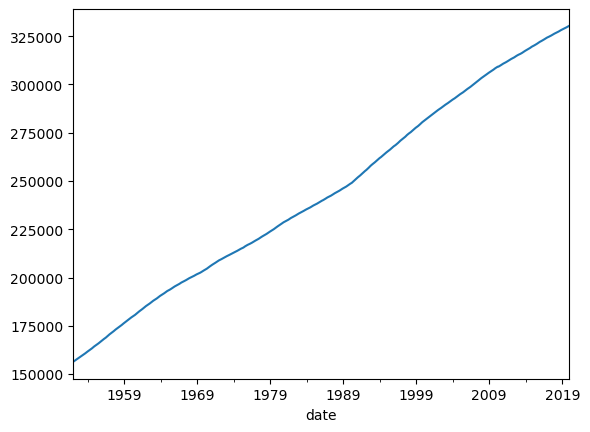

In [11]:
y = raw_data['value']
y.plot()
plt.show()

We can clearly see the population trending upwards as the years go on fairly consistently.

Next, I am going to use statsmodels' STL method to track better understand the seasonality and noise of this data.

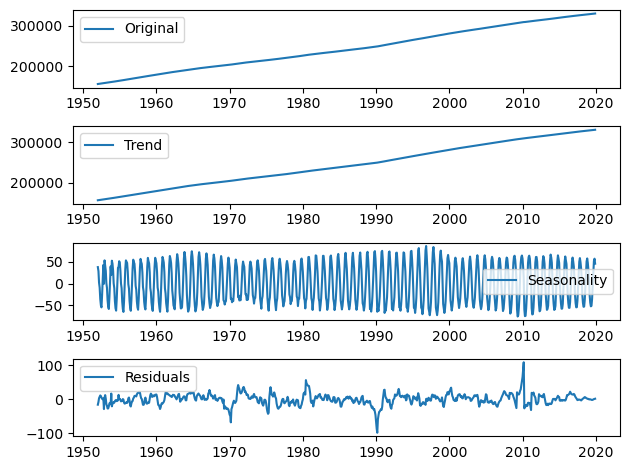

In [12]:
from statsmodels.tsa.seasonal import STL

raw_data = raw_data.asfreq('MS')
stl = STL(raw_data).fit()

trend = stl.trend
seasonal = stl.seasonal
residual = stl.resid

plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

We see a positive trend all the way through with some seasonality. 

## 3. Detrending for stationarity

The variance and covariance are consistent, but the mean increases over time. To make the data stationary, we will likely have to take the difference of the values from each other. First, I will use a kpss test to make sure that the data actually isn't stationary.

In [13]:
from statsmodels.tsa.stattools import kpss
kpss(y)

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(4.3845063699946225,
 0.01,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The null hypothesis here is that the data is stationary. With a p-value of less than .05, we reject the null hypothesis and confirm that the data is not stationary.

In [14]:
raw_data['value_diff'] = raw_data['value'].diff()
kpss(raw_data['value_diff'].dropna())

(0.3926507731271589,
 0.08032294261760392,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

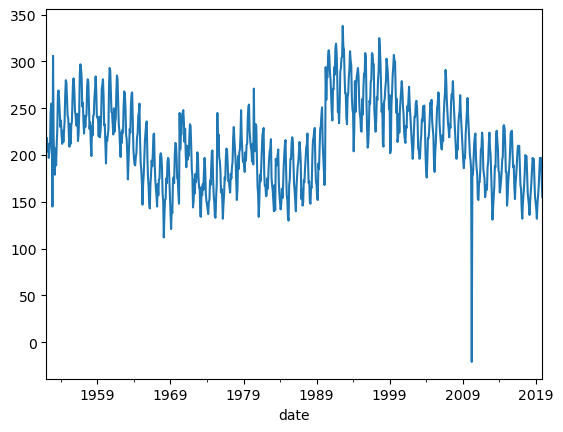

In [15]:
raw_data['value_diff'].plot()
plt.show()

I'm going to take the difference of these values one more time, after that we should see stationarity.

In [16]:
raw_data['value_diff2'] = raw_data['value_diff'].diff()
kpss(raw_data['value_diff2'].dropna())

C:\Users\Anthony\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.057233644142660106,
 0.1,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

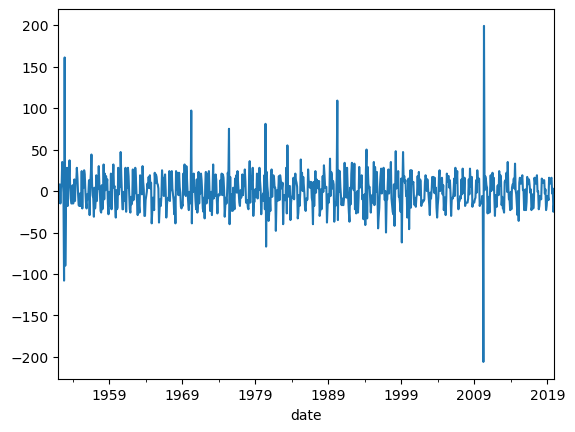

In [17]:
raw_data['value_diff2'].plot()
plt.show()

As we can see from both the plot and the kpss model, our data is now stationary and we now can use many more models for our predictions.

In [18]:
datapath = 'C:/Users/Anthony/Springboard/CapstoneThree/data/clean'
save_file(raw_data, 'clean_data.csv', datapath)

Writing file.  "C:/Users/Anthony/Springboard/CapstoneThree/data/clean\clean_data.csv"
